Importing The Dataset

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, StandardScaler
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

In [23]:
base_dir = "/Users/habib/Desktop/Arabic Sign Language/Butterflies"
train_df = pd.read_csv("/Users/habib/Desktop/Arabic Sign Language/Butterflies/Training_set.csv")  # Columns: filename, species
test_df = pd.read_csv("/Users/habib/Desktop/Arabic Sign Language/Butterflies/Testing_set.csv")    # Columns: filename

train_images = [os.path.join("/Users/habib/Desktop/Arabic Sign Language/Butterflies/train", f) for f in train_df['filename']]
test_images = [os.path.join("/Users/habib/Desktop/Arabic Sign Language/Butterflies/test", f) for f in test_df['filename']]

y_train = LabelEncoder().fit_transform(train_df['label'])

HOG

In [26]:
def extract_hog_fast(img_path):
    img = np.array(Image.open(img_path).resize((64, 64)) ) # Reduced from 128x128 for speed
    gray = rgb2gray(img) if len(img.shape) == 3 else img
    return hog(gray, 
              orientations=8,          # Reduced from 9
              pixels_per_cell=(16, 16), # Balanced speed/accuracy
              cells_per_block=(1, 1),   # Simplified from (3,3)
              channel_axis=None)

print("Extracting HOG features (parallel)...")
n_cores = max(1, multiprocessing.cpu_count() - 1)  # Leave 1 core free

X_train = np.array(Parallel(n_jobs=n_cores)(
    delayed(extract_hog_fast)(p) for p in tqdm(train_images, desc="Train Images")
))
X_test = np.array(Parallel(n_jobs=n_cores)(
    delayed(extract_hog_fast)(p) for p in tqdm(test_images, desc="Test Images")
))

Extracting HOG features (parallel)...


Test Images: 100%|██████████| 2786/2786 [00:01<00:00, 1535.73it/s]


Dimensionality Reduction

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA for visualization (keep 95% variance)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# LDA (for supervised projection)
lda = LinearDiscriminantAnalysis(n_components=min(10, len(np.unique(y_train))-1))
X_train_lda = lda.fit_transform(X_train_scaled, y_train)

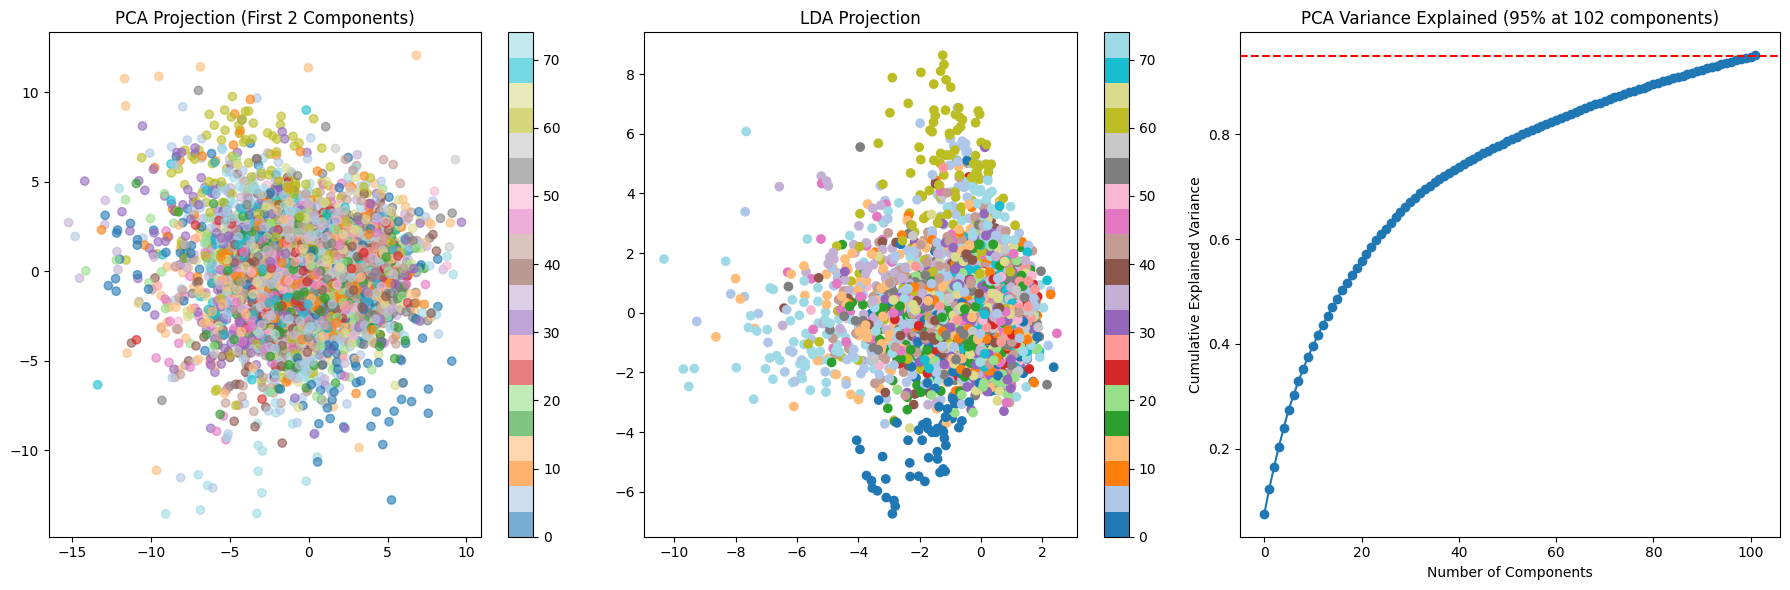

In [ ]:
plt.figure(figsize=(18, 6))
# PCA Projection
plt.subplot(131)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, cmap='tab20', alpha=0.6)
plt.title("PCA Projection (First 2 Components)")
plt.colorbar()
# LDA Projection
plt.subplot(132)
if X_train_lda.shape[1] > 1:
    scatter = plt.scatter(X_train_lda[:,0], X_train_lda[:,1], c=y_train, cmap='tab20')
    plt.title("LDA Projection")
    plt.colorbar(scatter)
else:
    plt.hist(X_train_lda, bins=30)
    plt.title("LDA Single Component")

# Explained Variance
plt.subplot(133)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title("PCA Variance Explained (95% at {} components)".format(pca.n_components_))

plt.tight_layout()
plt.show()  
plt.close()

Classifier Training

In [31]:
clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
clf.fit(X_train_pca, y_train)

SVC(C=10, probability=True)

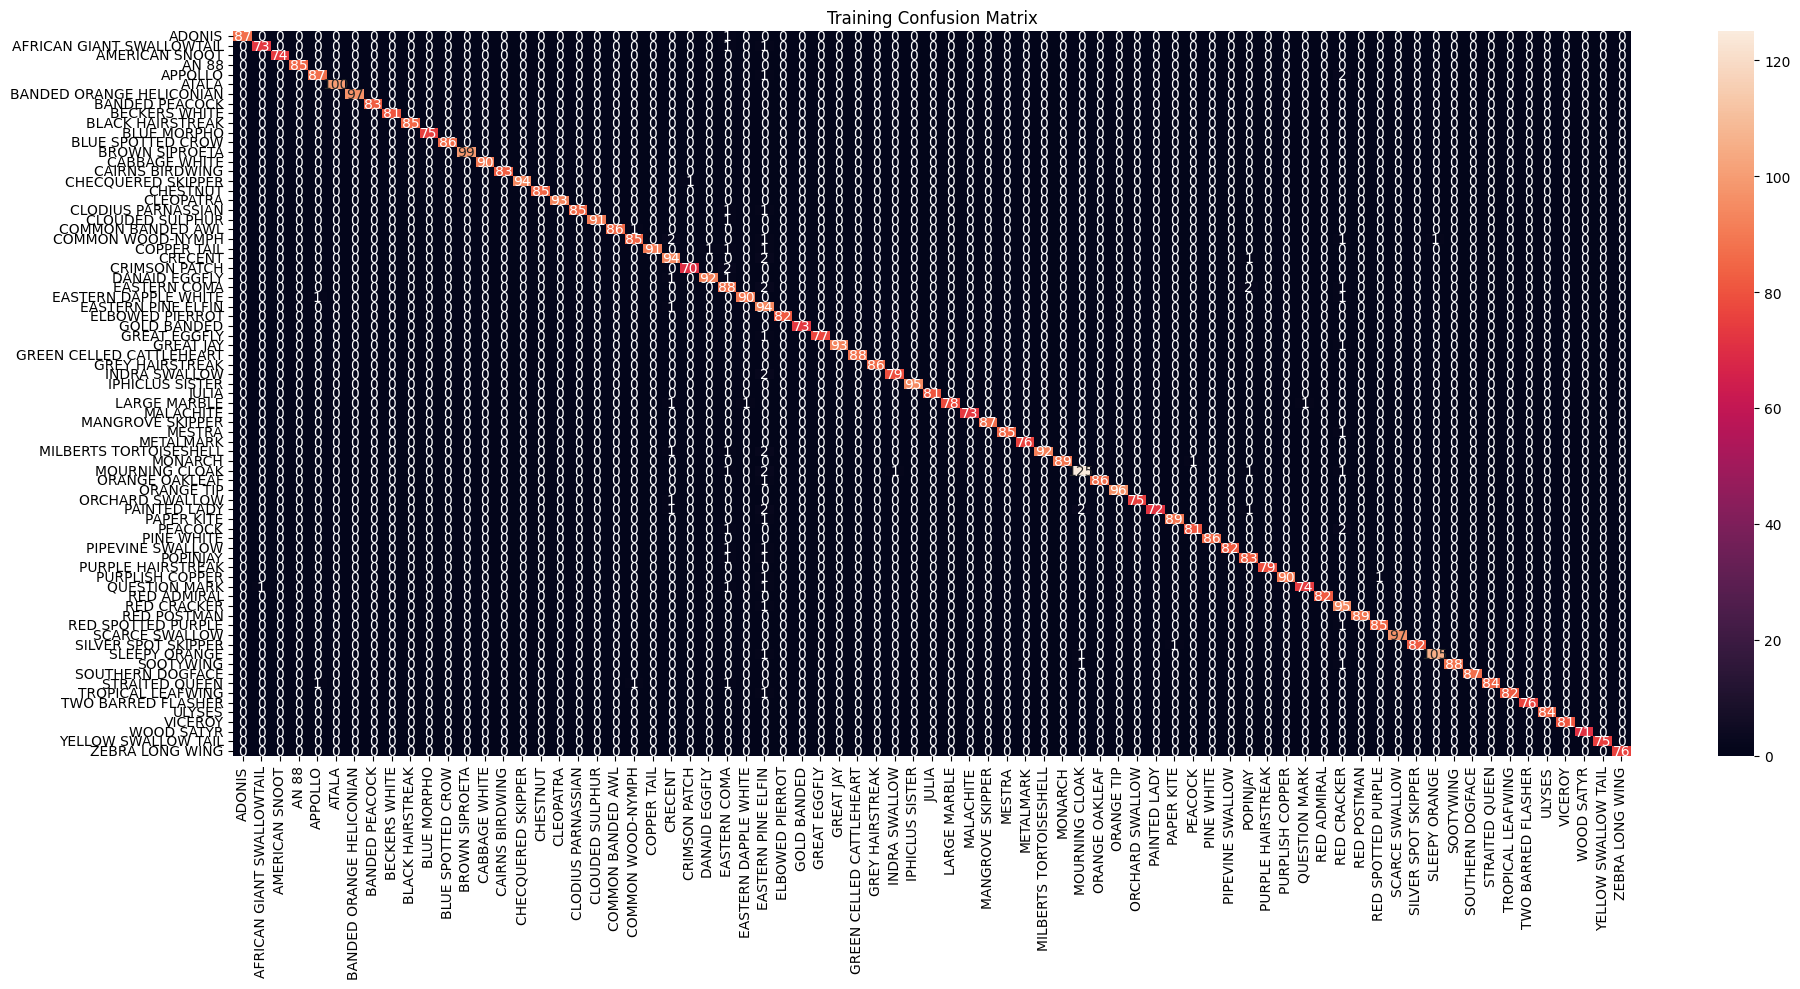

In [ ]:
#confusion matrix
y_pred = clf.predict(X_train_pca)
cm = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=np.unique(train_df['label']),
            yticklabels=np.unique(train_df['label']))
plt.title("Training Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
plt.close()

In [36]:
# 7. Evaluation Report
report = classification_report(y_train, y_pred, 
                             target_names=np.unique(train_df['label']))
print("\nClassification Report:\n", report)


Classification Report:
                            precision    recall  f1-score   support

                   ADONIS       1.00      0.99      0.99        88
AFRICAN GIANT SWALLOWTAIL       0.99      0.97      0.98        75
           AMERICAN SNOOT       1.00      1.00      1.00        74
                    AN 88       1.00      1.00      1.00        85
                  APPOLLO       0.98      0.97      0.97        90
                    ATALA       1.00      1.00      1.00       100
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00        97
           BANDED PEACOCK       1.00      1.00      1.00        83
            BECKERS WHITE       1.00      1.00      1.00        81
         BLACK HAIRSTREAK       1.00      1.00      1.00        85
              BLUE MORPHO       1.00      1.00      1.00        75
        BLUE SPOTTED CROW       1.00      1.00      1.00        86
           BROWN SIPROETA       1.00      1.00      1.00        99
            CABBAGE WHITE       1.00